# CA2: Predicting malignancy from features of breast cancer samples

**Please note that this assignment may be completed in groups.**

---
In this assignment, we'll develop models that predict malignancy in the [Wisconsin Breast Cancer Diagnosis Dataset][1] we explored last time.

As before, please note that there are a number of resources related to this dataset, including the following:
- [discussion and examples on kaggle][2]
- [Medium article similar to this assignment][3]

Goals are as follows:

- Become more comfortable with the Jupyter notebook format
- Explore common data exploration and visualization techniques
- Learn/review initial steps required to prepare a dataset for model development
- Consider which techniques are most useful for specific healthcare datasets

Each of our computational assignments will begin by importing a few required libraries using an `import` statement. These libraries extend the basic functionality of Python. By importing `as X` (e.g. `as np`), we can shorten subsequent calls to the library in our code.

- `numpy` for efficient math operations
- `pandas` for dataframes and dataframe operations
- `matplotlib` for visualization/plotting
- `sklearn` gives us a convenient way to load our dataset, as before, but this time we'll also use it to develop our models! The vast majority of "standard" machine learning models are implemented in this library. When working with specific neural network architectures, on the other hand -- this includes convolutional and recurrent neural networks -- we'll need to use a more customizable machine learning library like `tensorflow` or `pytorch`.

[1]: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
[2]: https://www.kaggle.com/shubamsumbria/breast-cancer-prediction
[3]: https://medium.com/analytics-vidhya/breast-cancer-diagnostic-dataset-eda-fa0de80f15bd

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the data

As in assignment 1, we'll use `sklearn` to load the dataset. Typically you might load from `.csv` with `pd.read_csv()`, from `.xlsx` with `pd.read_excel()`, etc., but the result would be the same: you'd end up with a `pandas` dataframe. In this case, `sklearn` gives us a nice way to load this dataframe without having to find and download a `.csv` file on our own.

We'll also create a function (`flip_some_labels()`) that will flip a portion of the labels `y_true` at random to make the prediction task more difficult. This will help us visualize differences in performance between models, including models that we will deliberately *overfit* to the training data. At the end of the assignment, we'll return to the true labels to see how well we can predict malignancy from the data.

In [2]:
from sklearn.datasets import load_breast_cancer
df, y_true = load_breast_cancer(return_X_y=True, as_frame=True)

def flip_some_labels(labels, flip_rate=.1, random_seed=0):
    return (labels + (np.random.RandomState(random_seed).rand(len(labels)) < flip_rate)) % 2

y = flip_some_labels(y_true)

We now have two objects: a dataframe `df` of predictors, and a single *series* (i.e. column) `y` of the associated outcomes. Since we explored this dataset last time, we can skip the descriptive statistics and plots. Still, let's do a quick `.head()` check just to make sure nothing has changed. We'll also check our outcomes by checking the `.value_counts()`.

In [3]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y.value_counts()

1    340
0    229
Name: target, dtype: int64

### Partitioning and standardizing the data

Since we explored this dataset in our previous assignment, we can now take a few more simple steps to prepare it for model development. First, note that there are 569 patients in our dataset. We can determine this by adding the value counts for y, or with `len(df)`. To keep things simple, we'll use the first 400 patients to train our models, and the remaining 169 to test them. We will *not* be defining a validation set in this exercise, at least not explicitly. However, some of our `sklearn` models will set aside part of our training set as a validation set during the training process. We'll come back to this point later in the assignment.

The final step prior to modeling will be to *standardize* our data by shifting it so that the mean is 0, then scaling it so that the standard deviation is 1. This step will make our model coefficients more interpretable and keep them all in the same range; the latter is particularly important for neural networks, and for models in which large coefficients are penalized (e.g. ridge regression).

All the features in this dataset are numeric, so (a) we won't have to worry about preparing categorical features for modeling, and (b) all of the features can (and should) be standardized.

We will also standardize our *test* set, but using the mean and standard deviation from our *training* set. Remember: we don't want **any** information from the test set -- not even its mean or standard deviation -- to be used when developing our models.

In [5]:
train_mean = df[:400].mean()
train_std = df[:400].std()

X_train = (df[:400] - train_mean) / train_std
X_test = (df[400:] - train_mean) / train_std

y_train = y[:400]
y_test = y[400:]

### More imports and a couple of helper functions

Here we'll import a number of functions and models from `sklearn`:
- `roc_curve()` and `roc_auc_score()` to help us plot the receiver operating characteristic (ROC) curve and calculate the area under the curve (AUC), respectively
- `precision_recall_curve()` and `average_precision_score()` to help us plot the precision recall (PR) curve and calculate the average precision, which is similar to the area under the PR curve
- The `LogisticRegression` model, which we will train using our dataset
- The `MLPClassifier` model, which is a multilayer perceptron like the ones we've discussed in class

We then define a function (`plot_roc_and_pr_curves()`) that will plot the ROC and PR curves, since we'll be doing this multiple times. This function first evaluates the AUC and average precision, then quantifies prediction performance across a range of decision thresholds in order to plot the ROC and PR curves. Most of the code controls figure aesthetics, and it is not important to understand the details. However, it *is* important that you understand the information presented in the ROC and PR curves.

Finally, we define a function (`print_accuracy()`) that calculates and prints the accuracy, which we'll also be doing for each model we train.

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

def plot_roc_and_pr_curves(labels, predicted_probabilities):
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    auc = roc_auc_score(labels, predicted_probabilities)
    ap = average_precision_score(labels, predicted_probabilities)
    
    fpr, tpr, _ = roc_curve(labels, predicted_probabilities)
    precision, recall, _ = precision_recall_curve(labels, predicted_probabilities)
    
    ax[0].plot(fpr, tpr, label='AUC = %.3f' % auc)
    ax[0].set_xlim([-.01, 1.01])
    ax[0].set_ylim([-.01, 1.01])
    ax[0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    ax[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    ax[0].plot([0, 1], [0, 1], 'k--', label='No information')
    ax[0].legend(loc='lower right', fontsize=14)
    
    ax[1].plot(recall, precision, label='Avg Precision = %.3f' % ap)
    ax[1].set_xlim([-.01, 1.01])
    ax[1].set_ylim([-.01, 1.01])
    ax[1].set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax[1].set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax[1].plot([0, 1], [labels.mean(), labels.mean()], 'k--', label='No information')
    ax[1].legend(loc='lower right', fontsize=14)

    plt.tight_layout()
    plt.show()
    
def print_accuracy(labels, predicted_labels):
    acc = (labels == predicted_labels).mean() * 100
    print('Accuracy = %.1f%%' % acc)

### Logistic Regression

We're finally ready to train and evaluate our first model: logistic regression. There are only a few lines of code in the block below, but each one is important.
- In the first line, we initialize the model, then `.fit()` it to our training set. We'll pass a `random_state` parameter when initializing *all* of our models to ensure that we'll get a consistent result even when there is randomness in the training procedure.
- In the second line, we predict the *probability* that `y` is 1 for each of the patients in our test set.
- In the third line, we predict the *value* of `y` based on this probability. Specifically, we'll predict that `y` is 1 whenever the predicted probability is greater than 0.5, otherwise we'll predict that `y` is 0.
- Finally, we'll use the functions defined in the previous block to print the accuracy and plot the ROC and PR curves.

We'll repeat these steps, with minor variations, each time we train a model.

Accuracy = 85.2%


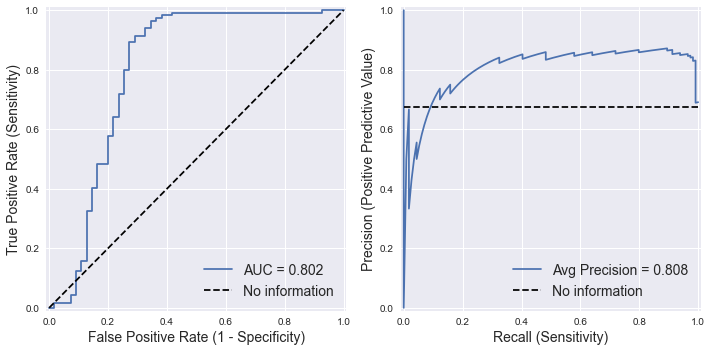

In [7]:
lr_model = LogisticRegression(random_state=0).fit(X_train, y_train)

y_test_pred_proba = lr_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_test, y_test_pred_label)
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

Our initial model is performing quite well! It achieves an accuracy of 85.2%, AUC of 0.802, and average precision of 0.808 on the test set.

## Question 1
In the ROC and PR curves above, there's a dotted line labeled as "No information" in the legend. This line tells us what performance we should expect when the predictors contain *no information* about the label, and our model is simply guessing the label at random. If the predictors *do* contain information about the label, on the other hand, then our curves should (for the most part) lie above these lines.

Consider the performance of a model that is guessing the label at random. For each of the following performance measures, please very briefly state (a) what value of that measure you'd expect this model to achieve, and (b) why. As an example, we'd expect an accuracy of 0.5 (i.e. 50%), because the model has a 50/50 chance of guessing any given label correctly, therefore its predictions will be correct 50% of the time on average.
- sensitivity
- specificity
- positive predictive value
- negative predictive value

---

### Multilayer Perceptron
We'll now follow the exact same steps as before, but using a multilayer perceptron instead of logistic regression. Unlike logistic regression, however, we'll need to provide a couple of additional details. 

First, we need to decide how many hidden layers to use, and how wide each of them should be. Here we'll tell `MLPClassifier` to use a single layer with 1000 neurons by specifying that `hidden_layer_sizes=(1000,)`. If we instead wanted to use two hidden layers with 100 neurons each, for example, we could use `hidden_layer_sizes=(100, 100)`.

Second, we'll set `early_stopping=True`. This tells the model to (a) set aside some of the data as a validation set, (b) continuously monitor performance on the validation set during training, and (c) stop training when performance on the validation set stops improving. This is a common and effective method to prevent the model from overfitting, and it also reduces the total training time.

Accuracy = 85.2%


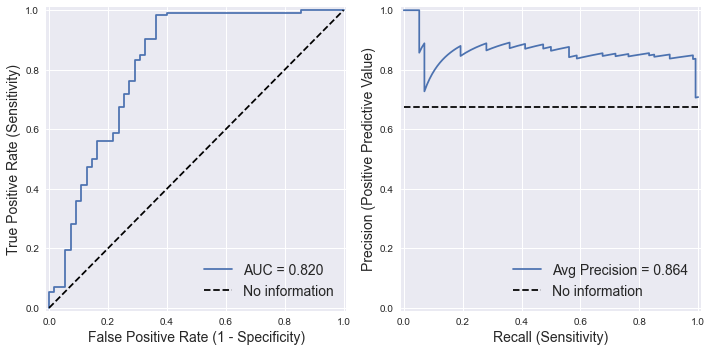

In [8]:
mlp_model = MLPClassifier(hidden_layer_sizes=(1000,), early_stopping=True, random_state=0).fit(X_train, y_train)

y_test_pred_proba = mlp_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_test, y_test_pred_label)
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

It looks like the multilayer perceptron did improve performance somewhat: the AUC increased to 0.820, and the average precision increased to 0.864. If we were deciding which of these models to use, we might want to test whether these improvements are statistically significant.

## Question 2
We've evaluated the performance of these models using four performance measures: accuracy, sensitivity, specificity, and positive predictive value. The ROC curve tells us about the tradeoff between sensitivity and specificity, whereas the PR curve tells us about the tradeoff between sensitivity and positive predictive value. If these models were used in a clinical environment to predict breast cancer malignancy, which measure(s) do you believe is/are most important to prioritize? Please describe your rationale in one brief paragraph (approx. 3-4 sentences), then propose an operating point -- in other words, a specific combination of sensitivity, specificity, and positive predictive value that is achievable based on the graphs above -- that you believe is appropriate for the task.

---

### Overfitting

We're now going to do something that **should not be done** to see why it's a bad idea: we're going to evaluate performance on the training set. It's fine to *monitor* performance on the training set -- sometimes this is done to make sure the model is training correctly -- but remember, performance on the training set is **not** a fair (i.e. unbiased) measure of performance. Let's go back to our logistic regression model, train it, and then evaluate performance on the same data used in training.

Accuracy = 86.5%


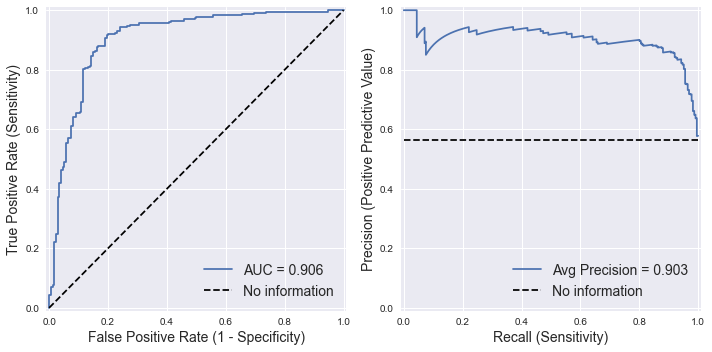

In [9]:
lr_model = LogisticRegression(random_state=0).fit(X_train, y_train)

y_train_pred_proba = lr_model.predict_proba(X_train)[:,1]
y_train_pred_label = (y_train_pred_proba > .5).astype(int)

print_accuracy(y_train, y_train_pred_label)
plot_roc_and_pr_curves(y_train, y_train_pred_proba)

### Much worse overfitting
As we suspected, performance is substantially better than it was on the test set: AUC jumps from 0.802 to 0.906, and average precision jumps from 0.808 to 0.903. Here we're using logistic regression, which has limited capacity to overfit when the number of patients is much greater than the number of predictors (i.e. $N \gg P$), as is the case here.

If we're already seeing overfitting with logistic regression, what will happen when we evaluate the performance of our multilayer perceptron on the training set? Let's find out! Unlike before, we *won't* use early stopping -- in other words, we *won't* use a validation set to decide when to stop training -- which will allow the model to dramatically overfit the training set.

Accuracy = 100.0%


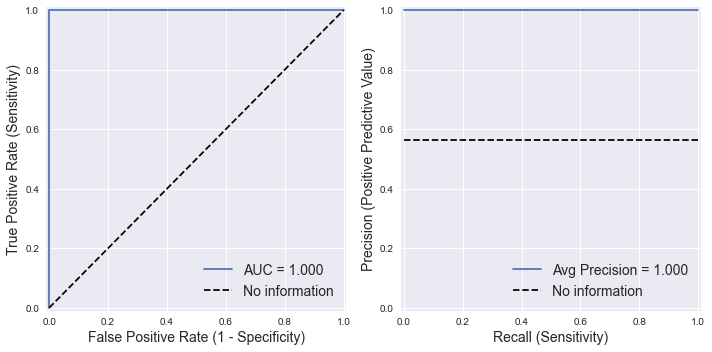

In [10]:
overfitted_mlp = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000, random_state=0).fit(X_train, y_train)

y_train_pred_proba = overfitted_mlp.predict_proba(X_train)[:,1]
y_train_pred_label = (y_train_pred_proba > .5).astype(int)

print_accuracy(y_train, y_train_pred_label)
plot_roc_and_pr_curves(y_train, y_train_pred_proba)

Our MLP has achieved **perfect** performance on the training set: intuitively, the model has enough parameters to simply *remember* all the training data and labels. As we will see below, however, these values are extremely misleading.

Accuracy = 82.2%


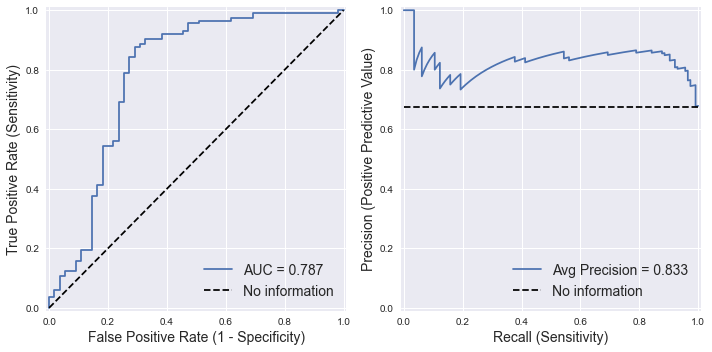

In [11]:
y_test_pred_proba = overfitted_mlp.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_test, y_test_pred_label)
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

As we suspected, performance on the test set is far from perfect. In fact, it's worse than our earlier logistic regression and MLP models. This is why it's called *overfitting*: we've trained our model to identify very specific patterns that do not generalize beyond the training data. Again, we can prevent this by using early stopping: we train until we see the initial signs of overfitting -- namely, that performance on the training and validation sets are beginning to diverge -- and then we stop.

## Question 3
As this example shows, it's very easy to overfit MLPs and other complex models, and the degree of overfitting tends to be much greater compared to simpler models like logistic regression. In your view, what are the implications for applying these models in a healthcare setting? Is this an argument for staying away from these models? Please discuss in one brief paragraph (approx. 3-4 sentences).

---

### Returning to the true labels
Finally, let's go back to `y_true` to see how well logistic regression performs on the original, true prediction task:

Accuracy = 97.0%


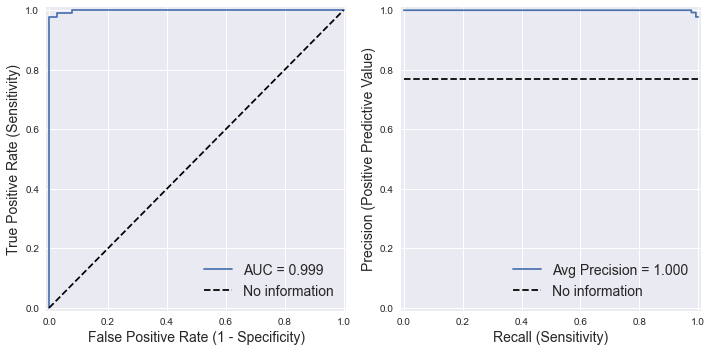

In [13]:
y_true_train = y_true[:400]
y_true_test = y_true[400:]

lr_model = LogisticRegression(random_state=0).fit(X_train, y_true_train)

y_test_pred_proba = lr_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_true_test, y_test_pred_label)
plot_roc_and_pr_curves(y_true_test, y_test_pred_proba)

It turns out that a very simple model -- logistic regression -- is highly effective for this prediction task!

## Question 4
Suppose we wanted to apply this model, which was trained using data from the University of Wisconsin, to breast cancer samples collected here at Duke. What obstacles would you anticipate and/or what concerns would you have? Would you recommend this approach, or something else? Please describe your reasoning in one brief paragraph (approx. 3-4 sentences).